In [3]:
# !pip install -r HopfieldAM/requirements.txt

In [2]:
!pip install rootutils

!touch /content/HopfieldAM/.project-root

import os
import rootutils

rootutils.setup_root(os.path.abspath('/content/HopfieldAM'), indicator=".project-root", pythonpath=True, dotenv=True, cwd=True)

PosixPath('/content/HopfieldAM')

In [3]:
import os
import rootutils

%load_ext autoreload
%autoreload 2

rootutils.setup_root(os.path.abspath('./'), indicator=".project-root", pythonpath=True, dotenv=True, cwd=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


PosixPath('/content/HopfieldAM')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
experiments_dir = "/content/drive/MyDrive/HopfieldAM_experiments/experiments_lr_e-3"

In [ ]:
import shutil
from argparse import Namespace

import jax.numpy as jnp

import pandas as pd
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax.random as random
import jax

import equinox as eqx
import optax
import numpy as np

import tensorflow_datasets as tfds

from config import CONFIG
from activation_map import ACTIVATION_MAP
from models import get_model
from losses import get_batch_loss
from datasets.dataset_loader import get_dataloader
from datasets.get_dimension import get_dimension
from src.train import train
from src.test import test
from utils.visualization import plot_metrics, plot_energy
from utils.integrate_trajectory import integrate_trajectory, get_energy
from utils.logger import new_run_id, log_experiment, log_summary
from utils.parse_config import parse_config

from tqdm.auto import tqdm
import os
import glob
import re

In [6]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "4"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [7]:
def get_best_checkpoint_path(activation, t1, dt, experiments_dir):
    """
    Find the best model checkpoint path given activation, t1, and dt parameters.

    Args:
        activation (str): Activation function name (e.g., 'gelu', 'relu', etc.)
        t1 (float): t1 parameter value
        dt (float): dt parameter value

    Returns:
        str: Path to the best model checkpoint or None if not found
    """

    t1_str = f"t1={t1}"
    dt_str = f"dt={dt}"

    # pattern to match directory names
    pattern = f"run_*_{activation}_{t1_str}_{dt_str}"

    # search for matching directories
    experiment_dirs = glob.glob(os.path.join(experiments_dir, pattern))

    if not experiment_dirs:
        return None

    # if multiple directories match, get the most recent one
    # (based on timestamp in directory name)
    if len(experiment_dirs) > 1:
        experiment_dirs.sort(reverse=True)

    target_dir = experiment_dirs[0]

    # get the best model file
    best_model_files = glob.glob(os.path.join(target_dir, "best_model*.eqx"))

    if not best_model_files:
        return None

    return best_model_files[0]

def load_best_model(args: Namespace, experiments_dir):
    ckpt_path = get_best_checkpoint_path(args.activation, args.t1, args.dt, experiments_dir)

    N_neurons = get_dimension(args.dataset_name)
    key = random.PRNGKey(19)
    g = ACTIVATION_MAP[args.activation]
    model = get_model(args.model, key=key, N_neurons=N_neurons, g=g)
    model = eqx.tree_deserialise_leaves(ckpt_path, like=model)
    return model

In [8]:
def create_batch_to_compute_energy(numbers: list, each_number_samples: int, dataset_name="mnist", split="test"):
    # load full dataset as arrays
    ds = tfds.load(dataset_name, split=split, as_supervised=True, batch_size=-1)
    images, labels = ds[0].numpy(), ds[1].numpy()  # Convert to numpy arrays

    selected_images = []
    selected_labels = []

    for number in numbers:
        # find indices for current number
        mask = labels == number
        indices = np.where(mask)[0]

        if len(indices) == 0:
            raise ValueError(f"Number {number} not found in {split} split")

        # sample with replacement if needed
        replace = len(indices) < each_number_samples
        selected_indices = np.random.choice(indices, size=each_number_samples, replace=replace)

        selected_images.append(images[selected_indices])
        selected_labels.append(labels[selected_indices])

    # combine and shuffle
    combined_images = np.concatenate(selected_images, axis=0)
    combined_labels = np.concatenate(selected_labels, axis=0)

    # shuffle the batch
    shuffle_idx = np.random.permutation(len(combined_images))

    X = jnp.array(combined_images[shuffle_idx]).squeeze()
    X = X.reshape(X.shape[0], -1)
    y = jnp.array(combined_labels[shuffle_idx])

    return X, y


In [ ]:
# train_loader, val_loader, test_loader = get_dataloader(dataset_name=args.dataset_name, batch_size=args.batch_size)
# batch_loss = get_batch_loss(args.loss)
# test_loss, test_accuracy = test(best_model, test_loader, batch_loss, args.dt, args.t1, args.N_classes)

---
## Energy plots for numbers:

In [9]:
experiments_dir = "/content/drive/MyDrive/HopfieldAM_experiments/experiments_lr_e-3"

In [10]:
args = Namespace(
    model="Hopfield",
    loss="loss_last10",
    dataset_name = "mnist",
    batch_size=128,

    activation = "relu",
    dt=0.01,
    t1=5.0,

    N_classes=10,
)

best_model = load_best_model(
    args,
    experiments_dir=experiments_dir)

In [11]:
X, y = create_batch_to_compute_energy(
    numbers=[0, 1],
    each_number_samples=1,
    dataset_name=args.dataset_name,
    split="test"
)
samples = y.shape[0]

In [12]:
def plot_energy(run_id, model, X_batch, y_batch, dt, t1, samples, save_plot=True, ylim=None, xlim=None, plot_mean=False, plot_only_mean=False, plot_path=None):

    X, y, ts, batch_E = get_energy(model, X_batch, y_batch, dt, t1, samples)
    output_dir = f"experiments/{run_id}"

    if plot_path is None:
        plot_path = os.path.join(output_dir, f"energy_plot_{samples}samples.png")

    # plot, coloring by digit
    plt.figure(figsize=(10, 6))
    colors = plt.get_cmap("tab10")  # 10 distinct colors

    for digit in range(10):
        idx = jnp.where(y == digit)[0]
        for i in idx:
            if not plot_only_mean:
                plt.plot(ts, batch_E[i],
                        color=colors(digit),
                        label=str(digit) if i == idx[0] else None,
                        alpha=0.7)
        # plt.plot(ts, ba)
        if plot_mean:
            E_mean_for_digit = jnp.mean(batch_E[idx], axis=0)

            if batch_E[idx].shape[0] > 0:
                plt.plot(ts, E_mean_for_digit,
                        linestyle="--",
                        color=colors(digit),
                        label=f"{digit}: <E>",
                        alpha=0.7)

    plt.xlabel("Time")
    plt.ylabel("Energy")
    plt.grid(alpha=0.4)
    plt.title(f"{run_id}: Energy vs Time for {samples} samples, (t ∈ [0,{t1}])")
    plt.legend(ncol=5, fontsize=10)

    if ylim is not None:
        plt.ylim(bottom=ylim[0], top=ylim[1])
    else:
        plt.ylim(bottom=min(batch_E.flatten()) * 1.1)  # show negative energies clearly

    if xlim is not None:
        plt.xlim(left=xlim[0], right=xlim[1])

    if save_plot:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(plot_path, bbox_inches="tight", dpi=300)
        print(f"Plot saved to {plot_path}")

    plt.show()
    plt.close("all")


In [13]:
from utils.energy_derivative import energy_derivative
from utils.integrate_trajectory import integrate_trajectory

In [14]:
def get_energy_dot(model, X_batch, y_batch, dt, t1, samples):
    N_steps = int(t1 / dt)
    ts = jnp.linspace(0.0, t1, N_steps + 1)

    X = X_batch[:samples]
    y = y_batch[:samples]

    batch_trajs = vmap(integrate_trajectory, in_axes=(None, 0, None, None, None))(
        model, X, dt, t1, ts
        )

    batch_E_dot = vmap(lambda traj: vmap(energy_derivative, in_axes=(None, 0))(model, traj))(batch_trajs)
    return X, y, ts, batch_E_dot

In [15]:
from jax import grad, random, config, vmap, jit

In [ ]:
"""old plot energy"""
def plot_energy(run_id, model, X_batch, y_batch, dt, t1, samples, save_plot=True):
    X, y, ts, batch_E = get_energy(model, X_batch, y_batch, dt, t1, samples)

    output_dir = f"experiments/{run_id}"
    plot_path = os.path.join(output_dir, f"energy_plot_{samples}samples.png")

    # plot, coloring by digit
    plt.figure(figsize=(10, 6))
    colors = plt.get_cmap("tab10")  # 10 distinct colors

    for digit in range(10):
        idx = jnp.where(y == digit)[0]
        for i in idx:
            plt.plot(ts, batch_E[i],
                    color=colors(digit),
                    label=str(digit) if i == idx[0] else None,
                    alpha=0.7)

    plt.xlabel("Time")
    plt.ylabel("Energy")
    plt.title(f"{run_id}: Energy vs Time for first {samples} samples (t ∈ [0,{t1}])")
    plt.legend(title="Digit", ncol=5, fontsize="small")
    plt.grid(alpha=0.4)
    plt.ylim(-50, 100)
    plt.ylim(bottom=min(batch_E.flatten()) * 1.1)  # show negative energies clearly

    if save_plot:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(plot_path)
        print(f"Plot saved to {plot_path}")

    plt.show()
    plt.close("all")

In [16]:
def plot_energy_dot(run_id, model, X_batch, y_batch, dt, t1, samples, save_plot=False):
    X, y, ts, batch_E = get_energy_dot(model, X_batch, y_batch, dt, t1, samples)

    output_dir = f"experiments/{run_id}"
    plot_path = os.path.join(output_dir, f"energy_plot_{samples}samples.png")

    # plot, coloring by digit
    plt.figure(figsize=(10, 6))
    colors = plt.get_cmap("tab10")  # 10 distinct colors

    for digit in range(10):
        idx = jnp.where(y == digit)[0]
        for i in idx:
            plt.plot(ts, batch_E[i],
                    color=colors(digit),
                    label=str(digit) if i == idx[0] else None,
                    alpha=0.7)

    plt.xlabel("Time")
    plt.ylabel("Energy")
    plt.title(f"{run_id}: Energy vs Time for first {samples} samples (t ∈ [0,{t1}])")
    plt.legend(title="Digit", ncol=5, fontsize="small")
    plt.grid(alpha=0.4)
    plt.ylim(-50, 100)
    plt.ylim(bottom=min(batch_E.flatten()) * 1.1)  # show negative energies clearly

    if save_plot:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(plot_path)
        print(f"Plot saved to {plot_path}")

    plt.show()
    plt.close("all")


In [17]:
def relu_derivative(y):
    """Computes the derivative of ReLU w.r.t. y using JAX"""
    return jnp.diag((y > 0).astype(float))

def energy_derivative(model, x):
    y = x / (jnp.linalg.norm(x))
    g = model.g(y)
    W = model.W
    I = jnp.eye(len(x))
    E_dot = (-W @ g + y).T @ (relu_derivative(y)) @ (I - jnp.outer(y, y)) @ (W @ g)
    return E_dot

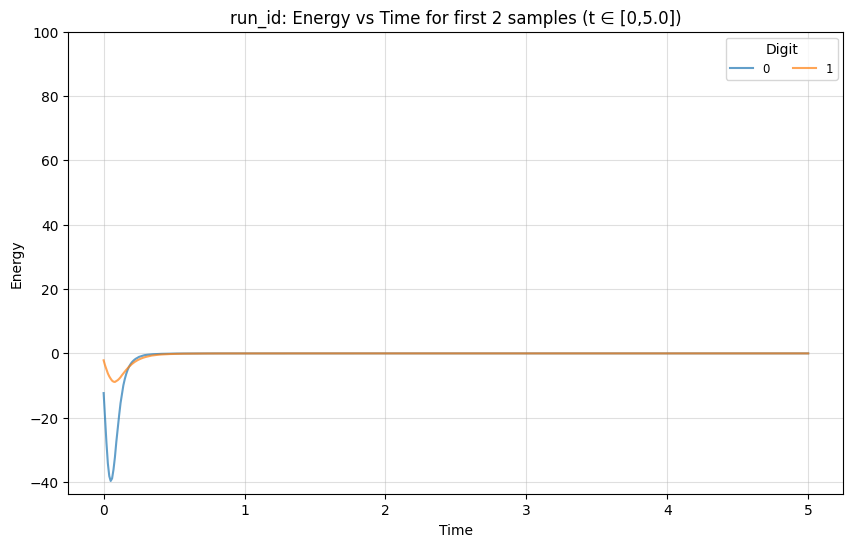

In [18]:
plot_energy_dot("run_id", best_model, X, y, args.dt, args.t1, samples, save_plot=False)

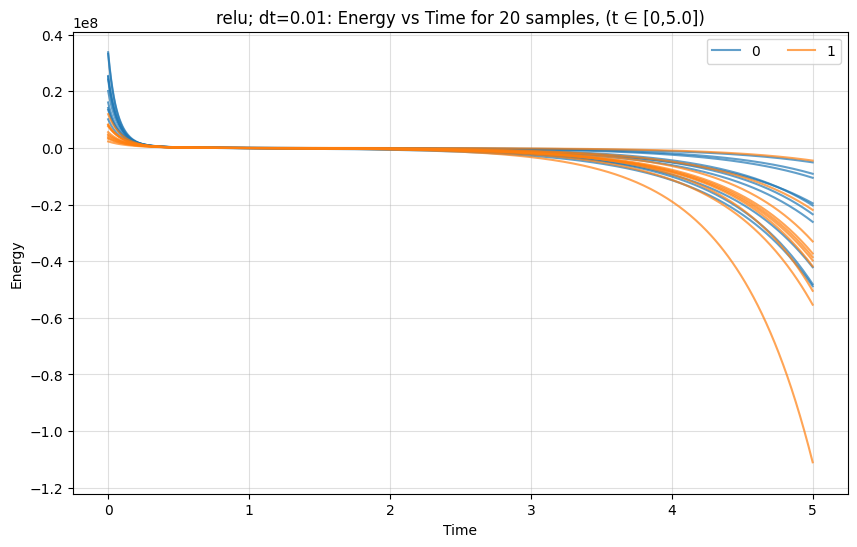

In [22]:
plot_energy(
    f"{args.activation}; dt={args.dt}",
    best_model,
    X,
    y,
    args.dt,
    args.t1,
    samples,
    save_plot=False,
    # ylim=(330, 370),
    # xlim=(10, 15.5),
    plot_only_mean=False
)